In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt

import param_scan
from tqdm.notebook import tqdm

# 3+1 Oscillation + Decay Scans

In [38]:
def run_scan(kwargs, filename, Npoints=10, path_results = "fit_data/", sin2theta_scan=False):

    # Range of mixings scanned 
    dm_Vec = np.geomspace(np.sqrt(1e-1), np.sqrt(1e5), Npoints)
    g_Vec = np.geomspace(1e-2, 10, Npoints)

    if sin2theta_scan:
        s2thetaSq = np.geomspace(1e-4, 0.5, Npoints)
        Umu4Sq = 0.5
        # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
        paramlist = param_scan.create_grid_of_params_sin2theta(g=g_Vec, m4=dm_Vec, sin2thetaSq=s2thetaSq, Um4Sq=Umu4Sq)
        
    else:
        Ue4Sq = np.geomspace(1e-3, 0.5, Npoints)
        Umu4Sq = np.geomspace(1e-3, 0.5, Npoints)
        # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
        paramlist = param_scan.create_grid_of_params(g=g_Vec, m4=dm_Vec, Ue4Sq=Ue4Sq, Um4Sq=Umu4Sq)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs)

    with Pool() as pool:
        res = np.array(list(pool.map(func_scan, paramlist)))
        # res = np.array(list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist))))

    param_scan.write_pickle(f"{path_results}/{filename}", res)
    return res

In [39]:
# Common attributes to all osc_only scans
kwargs_common = {
    'oscillations': True, 
    'decay': True, 
    'decouple_decay': False, 
    'energy_degradation': True, 
    'include_antineutrinos': True,
    'n_replications': 10}

# Full and Standard case
kwargs_std = {
    'disappearance': True, 
    'use_numu_MC': True,
    'undo_numu_normalization': False,
    **kwargs_common}

In [40]:
PERFORM_SCAN = False
if PERFORM_SCAN:
    n = 3
    _ = run_scan(kwargs_std, 'MH_decay_test_2', Npoints=n)

In [117]:
def load_scan_data(filename, wi=None, w_fixed=None):
    data = param_scan.pickle_read(filename)
    
    if wi is not None:
        cut_in_w = data[np.argmin(np.abs(data[:,wi] == w_fixed)), wi]
        data = data[(data[:,wi] == cut_in_w)]
    
    data_dic = {}
    data_dic['g'] = data[:,0]
    data_dic['m4'] = data[:,1]
    data_dic['Ue4SQR'] = data[:,2]
    data_dic['Umu4SQR'] = data[:,3]
    s2t = 4*data_dic['Ue4SQR']*data_dic['Umu4SQR']
    data_dic['sin2theta'] = np.round(s2t, decimals=6)
    data_dic['dm4SQR'] = data[:,1]**2
    
    data_dic['MiniApp_chi2'] =  data[:,-3]
    data_dic['MicroApp_chi2'] =  data[:,-2]
    data_dic['MicroApp_Asimov_chi2'] = data[:,-1] 

    data_dic['MiniApp_deltachi2'] = data_dic['MiniApp_chi2'] - np.min(data_dic['MiniApp_chi2'])
    data_dic['MicroApp_deltachi2'] = data_dic['MicroApp_chi2'] - np.min(data_dic['MicroApp_chi2'])
    data_dic['MicroApp_Asimov_deltachi2'] = data_dic['MicroApp_Asimov_chi2'] - np.min(data_dic['MicroApp_Asimov_chi2'])

    return data_dic


In [118]:
def profile_for_sin2theta(data_dic):
    dic_prof = {}
    # Profile each chi2
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MiniApp_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MiniApp_chi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_chi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_Asimov_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_Asimov_chi2'])
    return dic_prof

In [119]:
def draw_miniboone_contour(ax):
    # Official MiniBooNE contours 
    dm2, sin2, chi2 = np.genfromtxt('MiniTools/include/MB_data_release_2020/combined/likihood_surface_contNunubar.txt').T


    kwargs_interp = {'fine_gridx': len(np.unique(sin2)),  
                            'fine_gridy': len(np.unique(dm2)), 
                            'logx':True, 
                            'logy':True,
                            }

    X, Y, Z = pt.interp_grid(sin2, dm2, chi2 - chi2.min(), **kwargs_interp)
    ax = plt.contour(X,Y,Z, levels=[0, 2.3, 6.18, 11.83, 19.33], colors=['black','black','black'], zorder=1, alpha=1, linestyles=[(1,(2,0.5))])

In [120]:
data_full = load_scan_data('fit_data/MH_decay_test_30.pkl')
dic_full_prof = profile_for_sin2theta(data_full)
dic_g_one_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=0, w_fixed=1))
dic_g_twofive_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=0, w_fixed=2.5))


data_gfixed = load_scan_data('fit_data/MH_decay_test_30.pkl')
dic_gfixed = profile_for_sin2theta(data_full)
dic_g_one_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=0, w_fixed=1))
dic_g_twofive_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=0, w_fixed=2.5))



In [124]:
np.unique(dic['sin2theta'])

array([4.00000e-06, 5.00000e-06, 6.00000e-06, 8.00000e-06, 9.00000e-06,
       1.20000e-05, 1.40000e-05, 1.80000e-05, 2.20000e-05, 2.80000e-05,
       3.40000e-05, 4.20000e-05, 5.20000e-05, 6.50000e-05, 8.00000e-05,
       1.00000e-04, 1.23000e-04, 1.53000e-04, 1.89000e-04, 2.35000e-04,
       2.91000e-04, 3.60000e-04, 4.46000e-04, 5.53000e-04, 6.85000e-04,
       8.49000e-04, 1.05200e-03, 1.30300e-03, 1.61400e-03, 2.00000e-03,
       2.47800e-03, 3.07000e-03, 3.80400e-03, 4.71300e-03, 5.83900e-03,
       7.23500e-03, 8.96400e-03, 1.11060e-02, 1.37610e-02, 1.70490e-02,
       2.11240e-02, 2.61720e-02, 3.24270e-02, 4.01770e-02, 4.97790e-02,
       6.16760e-02, 7.64160e-02, 9.46790e-02, 1.17306e-01, 1.45341e-01,
       1.80076e-01, 2.23113e-01, 2.76435e-01, 3.42500e-01, 4.24354e-01,
       5.25770e-01, 6.51425e-01, 8.07109e-01])

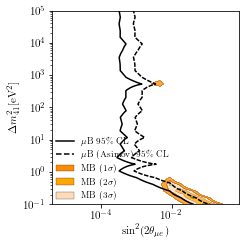

In [121]:
dic = dic_full_prof

fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)

kwargs_interp = {'fine_gridx': len(np.unique(dic['sin2theta'])),  
                'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                'logx':True, 
                'logy':True,
                }

levsMicroB = [11.83]
X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2']), **kwargs_interp)
cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83, 19.33], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83, 19.33], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)
# ax1.scatter(app_dic['sin2theta'], app_dic['dm4SQR'])

X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_chi2']-np.min(dic['MicroApp_chi2']), **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_Asimov_chi2']-np.min(dic['MicroApp_Asimov_chi2']), **kwargs_interp)
cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

# Official MiniBooNE contours 
# draw_miniboone_contour(ax1)

ax1.legend(loc=(0,0), fontsize=9)
# fig.savefig(f"{micro.path_plots}/MH_apponly.pdf", bbox_inches='tight', dpi=300)

### sin2theta_emu vs dm4 (profile over whatever else?)

In [54]:
def make_sin2thetaemu_plot(dic, name='default'):
    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"profiled -- " + name, fontsize=10)
    # ax1.set_xlim(1e-4,0.2)


    kwargs_interp = {'fine_gridx': len(np.unique(dic['sin2theta'])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True}
    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MiniApp_deltachi2'], **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83, 19.33], colors=['tomato','darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83, 19.33], colors=['black','black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)
    # ax1.scatter(app_dic['sin2theta'], app_dic['dm4SQR'])

    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_deltachi2'], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_Asimov_deltachi2'], **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='tomato', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($3 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($4 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')


    ax1.legend(loc=(0,0), fontsize=9)
    # fig.savefig(f"{micro.path_plots}/MH_full_osc_sin2thetaemuSQR_profiled.pdf", bbox_inches='tight', dpi=300)
    fig.savefig(f"{micro.path_plots}/MH_full_osc_sin2thetaemuSQR_profiled_{name}.pdf", bbox_inches='tight', dpi=300)

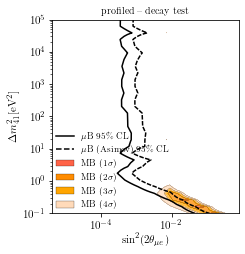

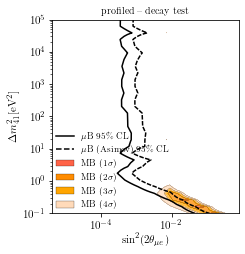

In [103]:
# make_sin2thetaemu_plot(dic_full, name='decay test')
make_sin2thetaemu_plot(dic_g_one_prof, name='decay test')
make_sin2thetaemu_plot(dic_g_twofive_prof, name='decay test')

### Ue4 vs dm4 (profile over Umu4)

In [125]:
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(filename, xi=2, yi=3, zi=1, wi=0, w_fixed=1, global_deltachi2=False):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    cut_in_w = data[np.argmin(np.abs(data[:,wi] == w_fixed)), wi]
    data = data[(data[:,wi] == cut_in_w)]
    
    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z, w = get_var(data,xi), get_var(data,yi), get_var(data,zi), get_var(data,wi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    
    z_slices = np.geomspace(np.min(z), np.max(z),9,endpoint=True)
    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
    # plt.subplots_adjust(hspace=0, wspace=0)
    axs = axs.flatten()
    for i, z_slice in enumerate(z_slices):
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)

        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i in [0,3,6]:
            ax.set_ylabel(string_slices[yi], fontproperties=pt.font)
        # else:
            # ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[xi], fontproperties=pt.font)
        else:
            ax.set_xticklabels([])
        ax.annotate(text=fr"{string_slices[zi]} $\,= {z_slice_true:.3f}$", 
                    xycoords='axes fraction', 
                    xy=(0.05,0.9), 
                    fontsize=11, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))

        le = len(np.unique(x))*5
        kwargs_interp = {'fine_gridx': le,  
                        'fine_gridy': le, 
                        'logx':True, 
                        'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
        
        cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
        cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', color='black',)
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on")
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        if i == 0:
            ax.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
            ax.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
            ax.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
            ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')
            ax.legend(loc=(0,0), fontsize=8)
    fig.suptitle(fr'{string_slices[wi]} $\,= {w_fixed:.2f}$')
    fig.savefig(f"{micro.path_plots}/{filename}_allslices_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=300)



<ipython-input-125-ddcb030249d4>:63: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)


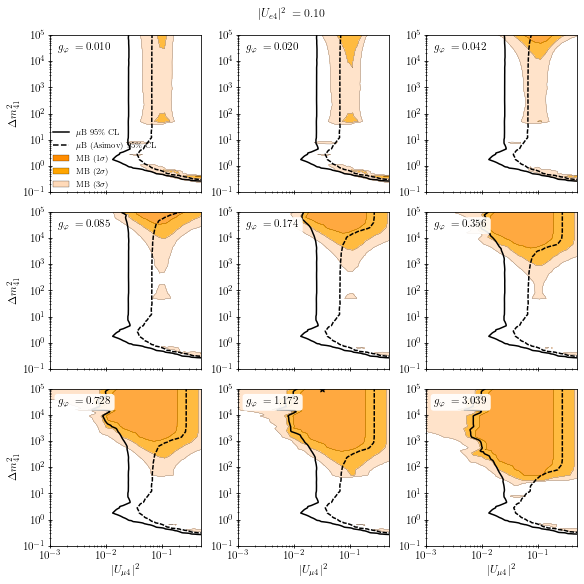

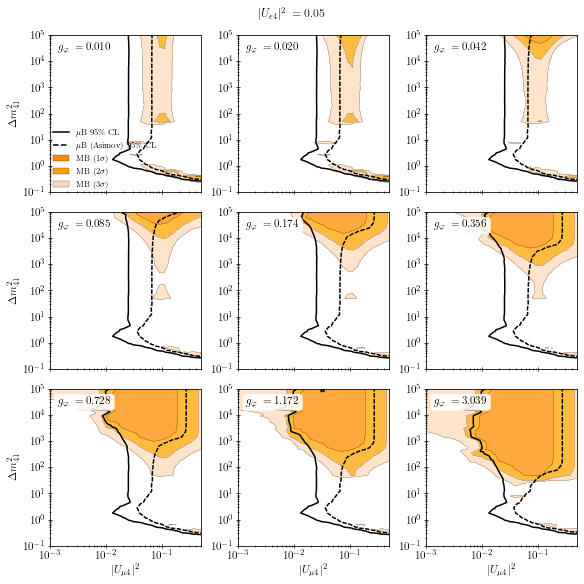

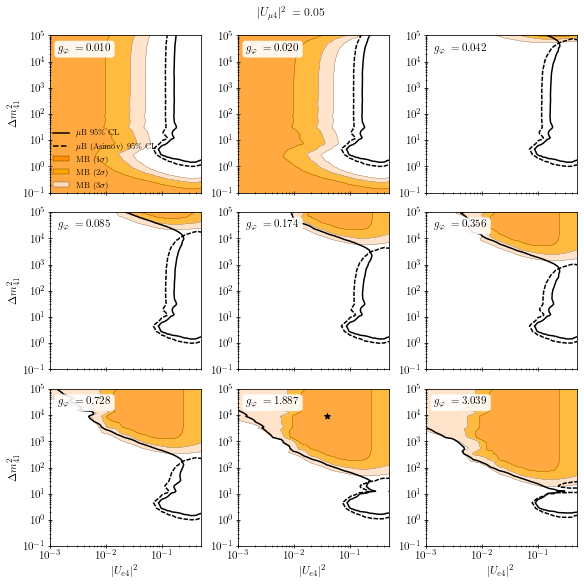

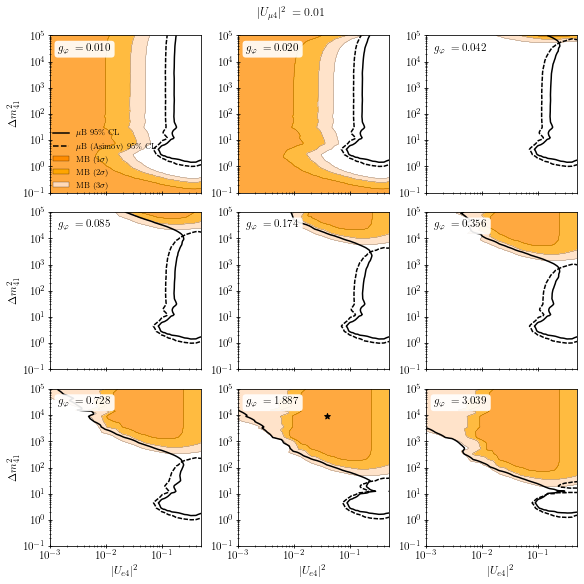

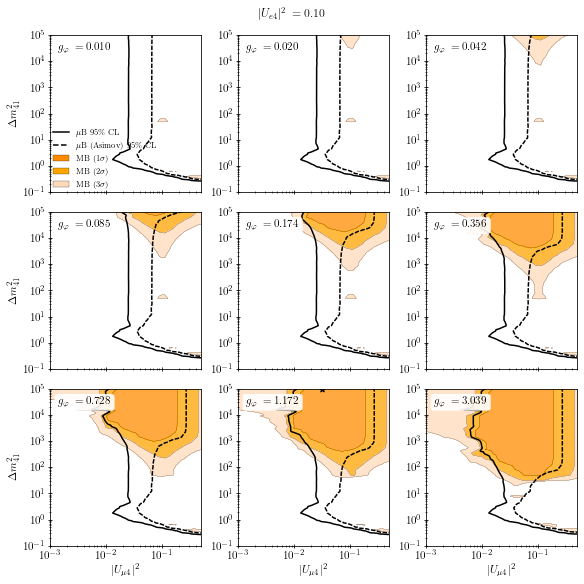

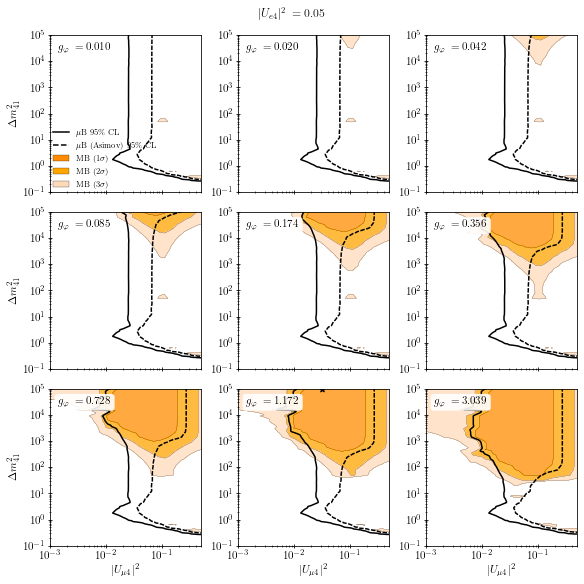

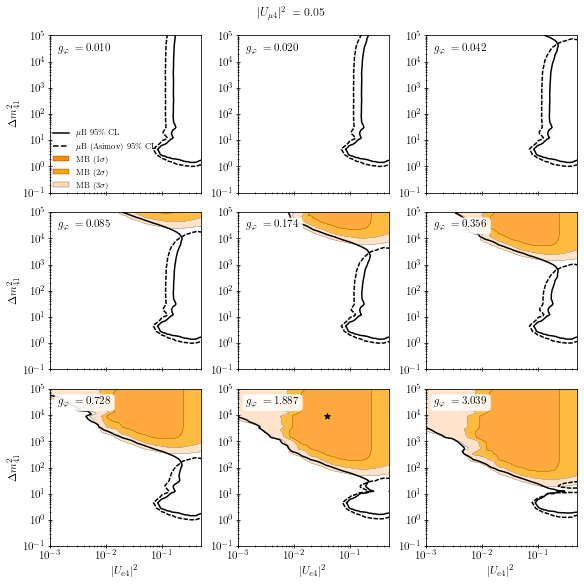

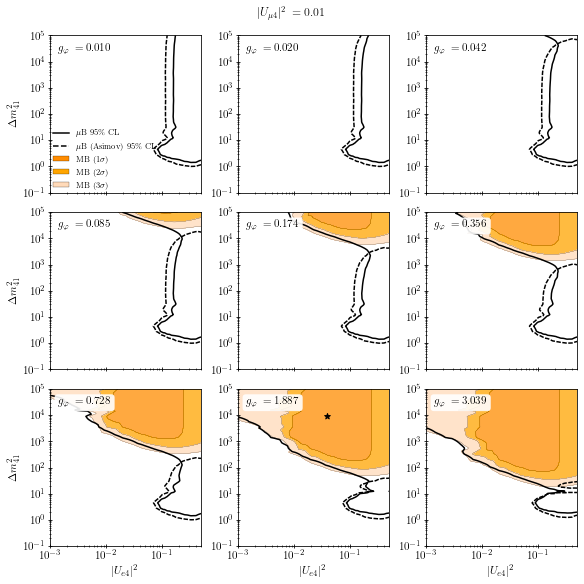

In [126]:
plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.1, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.05, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=False)

plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.1, global_deltachi2=True)
plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=True)
plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.05, global_deltachi2=True)
plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=True)

### Umu4 vs dm4 (profile over Ue4)

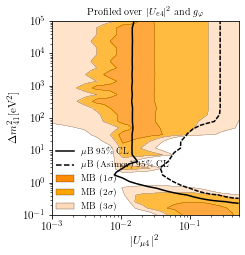

In [67]:
filenames = ['MH_decay_test_30']
for filename in filenames:
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

    
    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2

    # Profile each chi2
    prof_x, prof_y, prof_MiniApp_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MiniApp_deltachi2)
    prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MicroApp_deltachi2)
    prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MicroApp_Asimov_deltachi2)

    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.axis([xmin, xmax, ymin, ymax])
    # ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    # ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"Profiled over $|U_{{e 4}}|^2$ and $g_\varphi$", fontsize=10)

    le = len(np.unique(Ue4SQR))
    kwargs_interp = {'fine_gridx': le,  
                            'fine_gridy': le, 
                            'logx':True, 
                            'logy':True,
                            }

    X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    X, Y, Z = pt.interp_grid(prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

    ax1.legend(loc=(0,0), fontsize=9)
    fig.savefig(f"{micro.path_plots}/{filename}_umu4_profiled.pdf", bbox_inches='tight', dpi=300)

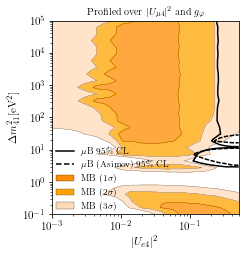

In [ ]:
filenames = ['MH_decay_test_30']
for filename in filenames:
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

    
    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2

    # Profile each chi2
    prof_x, prof_y, prof_MiniApp_deltachi2 = param_scan.profile_in_plane(Ue4SQR, dm4SQR, MiniApp_deltachi2)
    prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = param_scan.profile_in_plane(Ue4SQR, dm4SQR, MicroApp_deltachi2)
    prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = param_scan.profile_in_plane(Ue4SQR, dm4SQR, MicroApp_Asimov_deltachi2)

    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.axis([xmin, xmax, ymin, ymax])
    # ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    # ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_xlabel(r"$|U_{e 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"Profiled over $|U_{{\mu 4}}|^2$ and $g_\varphi$", fontsize=10)

    le = len(np.unique(Ue4SQR))
    kwargs_interp = {'fine_gridx': le,  
                        'fine_gridy': le, 
                        'logx':True, 
                        'logy':True,
                        }

    X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    X, Y, Z = pt.interp_grid(prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

    ax1.legend(loc=(0,0), fontsize=9)
    fig.savefig(f"{micro.path_plots}/{filename}_ue4_profiled.pdf", bbox_inches='tight', dpi=300)